Polynominale Logistische Regression zur Unterscheidung der Fehlerart.

Model soll die folgende Frage beantworten: Was ist der nächste Fehler?

Model nutzt für die Vorhersage die Temperatur und die Leistungsaufnahme

In [114]:
# Daten einlesen

%matplotlib inline
import pymssql
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt

password = "Masterprojekt"
conn = pymssql.connect("pcs.f4.htw-berlin.de",
                       "Masterprojekt", password, "PraediktiveAnalysenTest")
cursor = conn.cursor()

df = pd.read_sql('SELECT TOP 59863 * FROM Maschinendaten_20181206 ORDER BY ID DESC', conn)
conn.close()

In [115]:
# Sortierung umkehren, in neuer Variable speicher df_s s=sortiert
df_s = df.sort_values('ID', ascending = False)

In [116]:
# Datensätze filtern nach ... und in neuer Variable speichern df_f f=gefiltert
# ... ungeplanten Stillständen (Zufallsfehler)
df_f = df_s.query('FehlerID != "A000"')
df_f = df_s.query('FehlerID != "A001"')
df_f = df_s.query('FehlerID != "A002"')
df_f = df_s.query('FehlerID != "A003"')
df_f = df_s.query('FehlerID != "A004"')
#df_f

In [117]:
# FehlerID durchsuchen und Zähler anlegen, der angibt wie lang es bis zu nächsten Ausfall dauert
x = []
y = 0
fail = df_f['FehlerID']
for row in fail:
    if row == "x000":
        y += 1
        x.append(y)
    else:
        y = 0
        x.append(y)
        
# "Ausfallentfernung" an df_s anhängen
df_f['NaechsterAusfall']=x

#df_f

In [118]:
# Nächster Ausfall durchsuchen, neue Spalte erzeugen wenn <= 50 dann Wert 1, sonst Wert 0
x = []
y = 0
fail = df_f['NaechsterAusfall']
for row in fail:
    if row < 50:
        y = 1
        x.append(y)
    else:
        y = 0
        x.append(y)
        
# "Ausfallentfernung" an df_s anhängen
df_f['nA50']=x
#df_f

In [119]:
# Nächste FehlerID durchsuchen, neue Spalte mit Nächster FehlerID (nF001) erzeugen
nfail = []
nfail001 = []
y = False
z = 0
fail = df_f['FehlerID']
for row in fail:
    if row == "F001":
        y = "F001"
        z = 1
    elif row == "F002":
        y = "F002"
        z = 0
    else:
        y = y
        z = z
    nfail.append(y)
    nfail001.append(z)
# "Nächster FehlerID" an df_s anhängen
df_f['nF001'] = nfail001
df_f['nFail'] = nfail
#df_f.head(120)

In [120]:
# Datensätze filtern: alle mit Leistungsaufnahme < 17 raus
df_f = df_f.query('Leistungsaufnahme > 17')

# Datensätze filtern: alle mit Nächster Ausfall > 50 raus
df_f = df_f.query('NaechsterAusfall < 50')
df_f = df_f.query('NaechsterAusfall > 0')
df_f = df_f.query('nFail != False')
#df_f

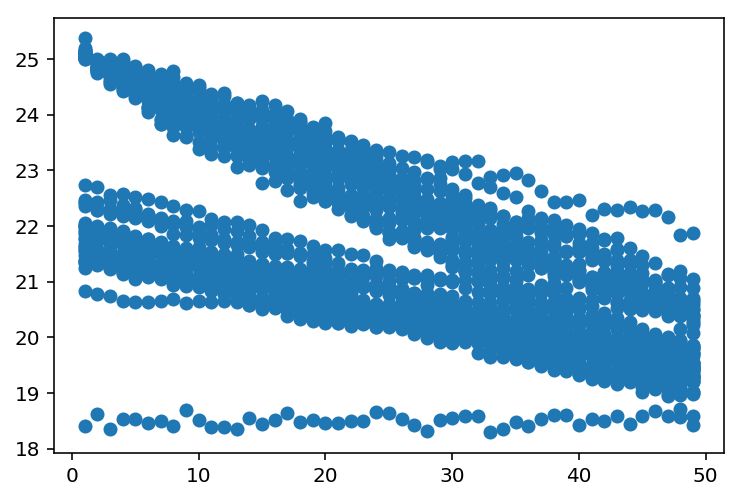

In [121]:
# Scatterplott mit Nächster Ausfall und Leistungsaufnahme anlegen
plt.scatter(df_f['NaechsterAusfall'], df_f['Leistungsaufnahme'])
plt.show()

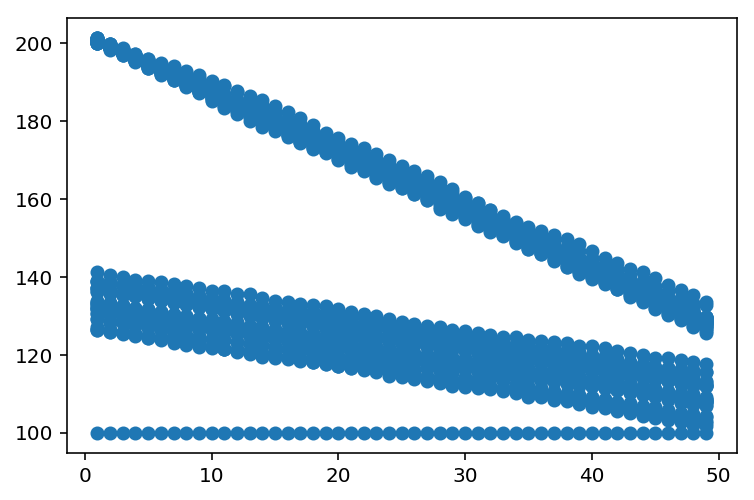

In [122]:
# Scatterplott mit Nächster Ausfall und Temperatur anlegen
plt.scatter(df_f['NaechsterAusfall'], df_f['Temperatur'])
plt.show()

In [123]:
# Model anhand 90 % der Daten erstellen
from sklearn.model_selection import train_test_split
X = df_f[["Temperatur", "Leistungsaufnahme"]].values
y = df_f["nF001"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [124]:
# Modeldaten skalieren, um sie für die lineare Regression nutzbar zu machen
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

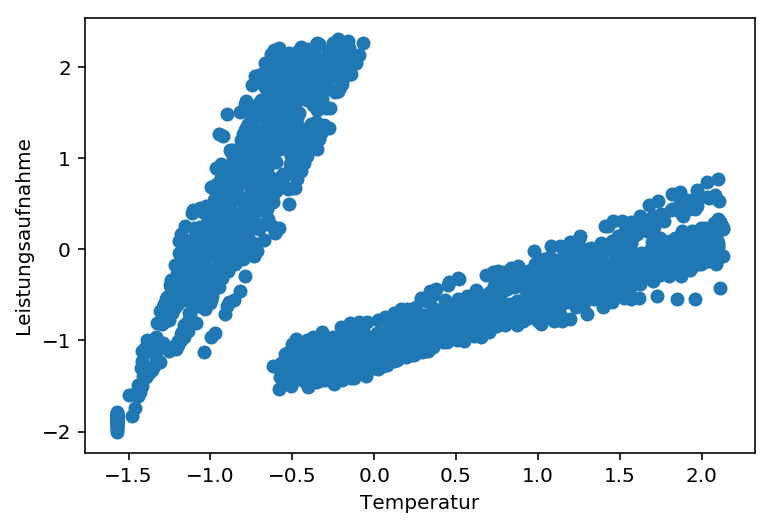

In [125]:
# Modeldaten plotten
plt.scatter(X_train[:,0], X_train[:,1])
plt.xlabel("Temperatur")
plt.ylabel("Leistungsaufnahme")
plt.show()

In [126]:
# Logistisches Regressionsmodel erstellen
from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
model.fit(X_train, y_train)
y_predicted = model.predict(X_test)

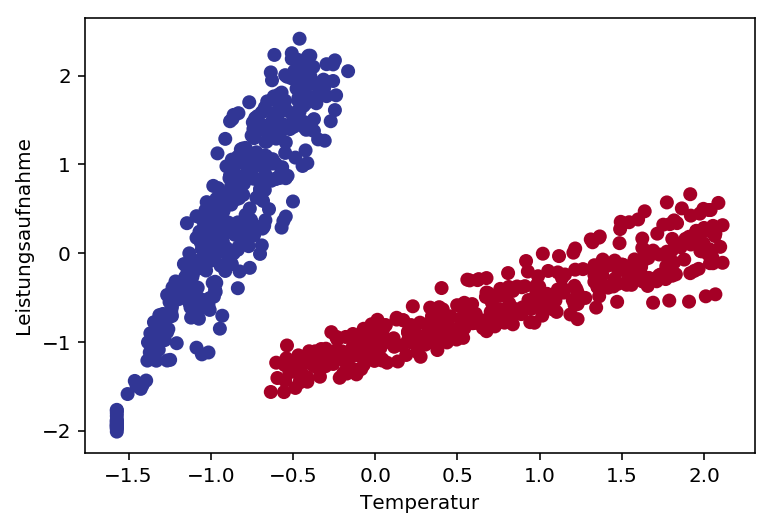

In [127]:
# Test-Modeldaten plotten, Farbwerte = echte nA20 Werte
plt.scatter(X_test[:,0], X_test[:,1], c= y_test)
plt.xlabel("Temperatur")
plt.ylabel("Leistungsaufnahme")
plt.show()

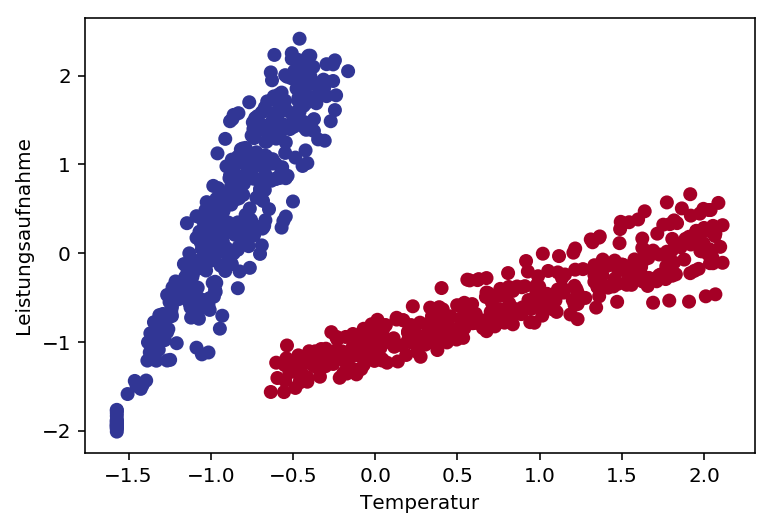

In [128]:
# Test-Modeldaten plotten, Farbwerte = vorhergesagte nA20 Werte
plt.scatter(X_test[:,0], X_test[:,1],c = y_predicted)
plt.xlabel("Temperatur")
plt.ylabel("Leistungsaufnahme")
plt.show()

In [129]:
# Anteil der korrekten Vorhersagen berechnen
model.score(X_test, y_test)

1.0

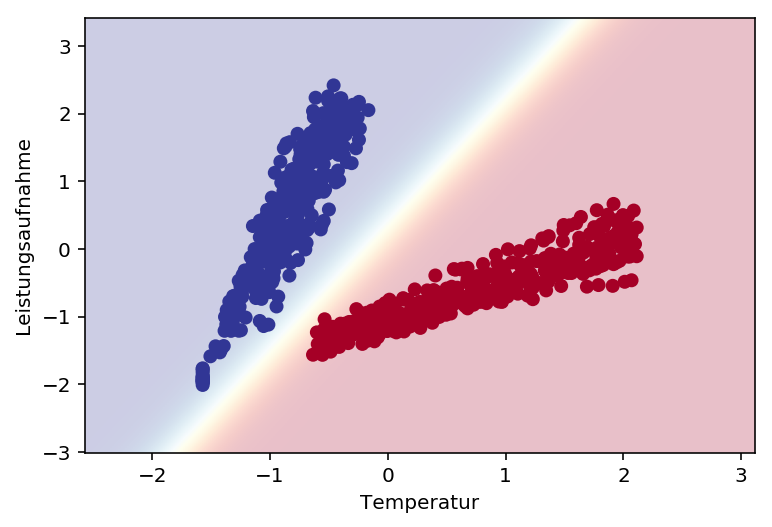

In [130]:
# Entscheidungsgrenze visualisieren
from helper import plot_classifier
plot_classifier(model, X_test, y_test, proba = True, xlabel = "Temperatur", ylabel = "Leistungsaufnahme")

In [131]:
# Predictions des zuletzt gelieferten Wertes
p = df.tail(1)
p = p[["Temperatur", "Leistungsaufnahme"]].values
p = scaler.transform(p)
model.predict(p)

array([1], dtype=int64)

In [132]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_predicted)

array([[387,   0],
       [  0, 407]], dtype=int64)